In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../src')
import monte_carlo as mc
import black_scholes as bs
import binomial_tree as bt
import payoff as po
import vol_arb as va
from scipy.stats import norm

# Volatility arbitrage

In this notebook, we explore a simple example of *volatility arbitrage*.  
The basic idea is that when the **implied volatility** used in option pricing differs from the **realized volatility** of the underlying asset, a hedged option position may systematically generate profit or loss when the volatility assumed for pricing or hedging differs from the realized volatility of the underlying asset.

We will:

- Review the mathematical setup and the role of implied, realized and hedging volatilities.  
- Derive the key expressions that determine the hedged P&L in the discrete re-hedging case. 
- Take the continuous limit and recover the result of Carr (2005):
\begin{equation}
\text{P}(\Pi_T) =V^{(\sigma_h)}(S_0,t_0)-V^{(\sigma_{\text{imp}})}(S_0,t_0)+\frac12(\sigma^2-\sigma^2_h) \int_0^T   e^{-rt}  S^2 \Gamma^{(\sigma_h)} dt \,. \nonumber
\end{equation}
- Use simulation to illustrate how profit arises when volatilities are mismatched, and show convergence to the continuous-time result.

## Mathematical setup

Let the asset follow a Black–Scholes dynamics:

\begin{equation}
dS/S = \mu \mathrm{d}t+ \sigma \mathrm{d}W\,,
 \tag{1}
\end{equation}

An option is priced under an **implied volatility** $\sigma_\text{imp}$, but the market actually evolves with **realized volatility** $\sigma$.  

Under the Black–Scholes model with implied volatility $\sigma_{\text{imp}}$, the option price $V^{(\sigma_{\text{imp}})}$ satisfies the PDE:
\begin{align}
&\left(\frac{\partial V^{(\sigma_{\text{imp}})}}{\partial t}\right)+\frac12 \sigma^2_{\text{imp}}S^2\left(\frac{\partial^2 V^{(\sigma_{\text{imp}})}}{\partial S^2}\right) + rS\left(\frac{\partial V^{(\sigma_{\text{imp}})}}{\partial S}\right)-rV^{(\sigma_{\text{imp}})} \tag{2}
\\
&\equiv \Theta^{(\sigma_{\text{imp}})}+\frac12 \sigma^2_{\text{imp}}S^2 \Gamma^{(\sigma_{\text{imp}})}+r S  \Delta^{(\sigma_{\text{imp}})}-rV^{(\sigma_{\text{imp}})} =  0\,, \nonumber
\end{align}
with the appropriate boundary condition, namely $V^{(\sigma_{\text{imp}})} \to \text{Payoff}(S_T,T)$.
The change in $dV^{(\sigma_{\text{imp}})}$ given by 
\begin{align}
dV^{(\sigma_{\text{imp}})} &= \left(\Theta^{(\sigma_{\text{imp}})}+\frac12 \sigma^2 S^2 \Gamma^{(\sigma_{\text{imp}})} \right)dt + \Delta^{(\sigma_{\text{imp}})} dS \tag{3}
\\
&=  \left(-r S  \Delta^{(\sigma_{\text{imp}})}+rV^{(\sigma_{\text{imp}})}+\frac12 (\sigma^2-\sigma^2_{\text{imp}}) S^2 \Gamma^{(\sigma_{\text{imp}})} \right)dt + \Delta^{(\sigma_{\text{imp}})} dS\nonumber
\end{align}
where we used Itô's lemma. We constrcut a portfolio of a long-call short-stock,
\begin{equation}
\Pi = C-\Delta S\,.
\tag{4}
\end{equation}
We re-hedge the portfolio by adjusting $\Delta^{(\sigma_h)} \equiv \left(\frac{\partial V^{(\sigma_{\text{h}})}}{\partial S}\right)$, where $\sigma_h$ is our choice of hedging volatility. $V^{(\sigma_{\text{h}})}$ satisfies a BS equation, see Eq. (2), and varies as in Eq. (3), both with the replcament $\sigma_{\text{imp}} \to\sigma_{\text{h}}$.

The total discounted profit for our *discrete* re-hedging scheme is then given by
\begin{equation}
\text{P}(\Pi_T) = \underbrace{-V^{(\sigma_{\text{imp}})}(S_0,t_0)+\Delta^{(\sigma_h)}_0 S_0}_{\text{Initial cash from setting up }\Pi} +\underbrace{\sum_{i=1}^{n-1} (\delta \Delta^{(\sigma_h)}_i) S_i e^{-r(i\Delta t) }}_{\text{cashflow from re-hedging}}+\underbrace{e^{-rT}\left(V(S_n,T)-\Delta^{(\sigma_h)}_{n-1} S_n\right)}_{\text{Option payoff and cost of closing short position}}\,,  
\tag{5}
\end{equation}
where we denoted,

\begin{equation}
\delta \Delta^{(\sigma_h)}_i \equiv \Delta^{(\sigma_h)}_i-\Delta^{(\sigma_h)}_{i-1}\,,
\tag{6}
\end{equation}

\begin{equation}
n \equiv T/\Delta t \,.
\tag{7}
\end{equation}
$T$ is the expiry time and present day is set to $t=0$. Our time grid is denoted by indices starting from $i=0$ ($t=0$) until $i=n$ ($t=T$). Independent of the implied volatility, at expiry we have $V(S_T,T) = \text{max}[S_T-K,0]\,.$



The numerical results below can be more easily understood in the continuous limit.
Let us examine the P&L terms from re-hedging. First we rewrite the sum as left-endpoint Riemann sums so we can readily turn them into an integral,
\begin{align}
\sum_{i=1}^{n-1}e^{-r\,i\Delta t}S_i \,\delta \Delta^{(\sigma_h)}_i &= \sum_{i=1}^{n-1}e^{-r\,i\Delta t}S_{i-1} \,\delta \Delta^{(\sigma_h)}_i+\sum_{i=1}^{n-1}e^{-r\,i\Delta t}(S_i-S_{i-1}) \,\delta \Delta^{(\sigma_h)}_i
\tag{8}
\\
&\to \int_0^T e^{-rt} \left(S \mathrm{d} \Delta^{(\sigma_h)}+d[S,\Delta^{(\sigma_h)}] \right)\nonumber\,,
\end{align}
where we kept the quadratic covariation as usual in stochastic calculus. Using Itô's product rule
\begin{align}
d(e^{-rt} S \Delta) = e^{-rt}S d\Delta+e^{-rt}\Delta dS + e^{-rt}d[S,\Delta^{(\sigma_h)}]-r e^{-rt} S \Delta dt\,, 
\tag{9}
\end{align}
we can finally write the integral as
\begin{align}
\sum_{i=1}^{n-1}e^{-r\,i\Delta t}S_i \,\delta \Delta^{(\sigma_h)}_i \to \int_0^T  \left(d( e^{-rt} S \Delta^{(\sigma_h)})+r e^{-rt} S \Delta dt- e^{-rt}\Delta^{(\sigma_h)} dS\right)\,,
\tag{10}
\end{align}
recovering Eq. (36) from Carr (2005). Using Black-Scholes we can replace the last term $\Delta^{(\sigma_h)} dS$, to find
\begin{align}
\int_0^T  \left(d(e^{-rt} S \Delta^{(\sigma_h)})- d(e^{-rt} V^{(\sigma_h)})+\frac12 e^{-rt} (\sigma^2-\sigma^2_h) S^2 \Gamma^{(\sigma_h)} dt \right)\,.
\tag{11}
\end{align}
The first two terms can be evaluted at the end-points, while the last must be integrated along the path. We find the total discounted P&L in the continous limit to be
\begin{align}
\text{P}(\Pi_T) =V^{(\sigma_h)}(S_0,t_0)-V^{(\sigma_{\text{imp}})}(S_0,t_0)+\frac12(\sigma^2-\sigma^2_h) \int_0^T   e^{-rt}  S^2 \Gamma^{(\sigma_h)} dt \,,
\tag{12}
\end{align} 
as shown by Carr (2005). The calculation confirms that the path-dependence deminished as the hedging volatility approaches $\sigma$. 

## Numerical simulations
We compare P&L distributions as a function of $\sigma_h$. The deterministic dependence on $\sigma_{\text{imp}}$ appears only in the first term of Eq. (12). The average profit is generally larger when $\sigma_{\text{imp}}$ is smaller, and decreases as $\sigma_{\text{imp}}$ approaches the realized volatility $\sigma$ from below. The portfolio ceases to be profitable once $\sigma_{\text{imp}}>\sigma$, i.e. when the option is over-priced relative to its ‘true’ value. In that case, the opposite position (long stock, short option) becomes profitable on average.

In [4]:
S0=100
mu=0.03
r=0.05
K=100 
sigmaImp=0.2
sigmaReal=0.3 
m=5000
T=6/12
D=0.0

In [5]:
dt = 1/(252)
MC = mc.GBM_time_series_fast(S0, mu, sigmaReal, T,dt,m)
sigmaH_range = np.linspace(0.1,0.7,50)
dists = []
dists_percentiles = []
dists_std = []
for sigmaH in  sigmaH_range:
    dist,p,std = va.vol_arb(S0,r,K,D,sigmaH,sigmaReal,sigmaImp,T,dt,MC,True)
    dists.append(dist)
    dists_percentiles.append(p)
    dists_std.append(std)
dists = np.array(dists)
dists_percentiles = np.array(dists_percentiles)#+bs.bs_formula_price(S0,K,r,D,sigmaImp,T,'call') #SHIFTED!
dists_std = np.array(dists_std)


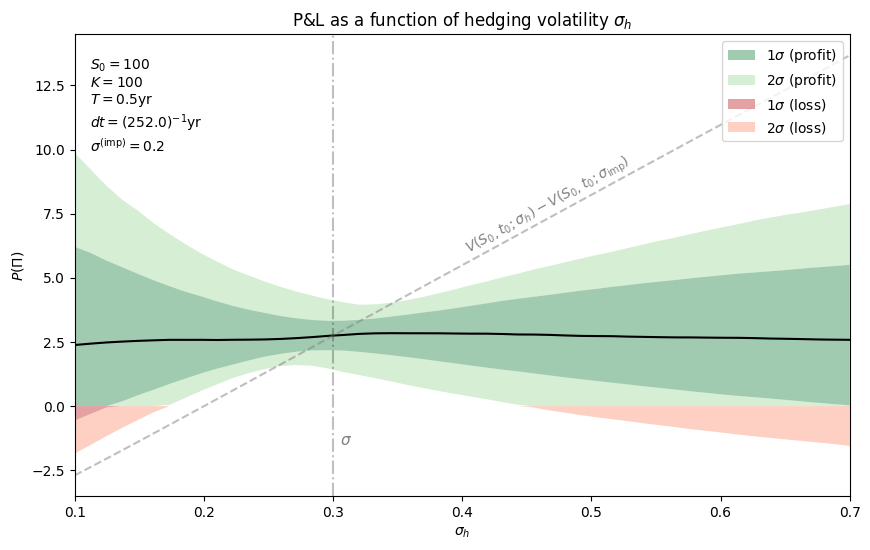

In [6]:
fig, ax = plt.subplots(figsize=(10,6))

colors= [plt.cm.Greens(0.8), plt.cm.Greens(0.4)]
colorsR= [plt.cm.Reds(0.8), plt.cm.Reds(0.4)]

# ax.plot(sigmaH_range,np.maximum(dists_percentiles[:,0],0),color=colors[1],alpha=0.5)
# ax.plot(sigmaH_range,result[:,1],color=colors[0],alpha=0.00)
ax.plot(sigmaH_range,dists_percentiles[:,2],color='black')
# ax.plot(sigmaH_range,[bs.bs_formula_price(S0,K,r,D,x,T,'call') for x in sigmaH_range],color='black',linestyle='--',alpha=0.5,label=r'$V(S_0,t_0;\sigma_h)$')
# ax.plot(sigmaH_range,result[:,3],color=colors[0],alpha=0.00)
# ax.plot(sigmaH_range,result[:,4],color=colors[1],alpha=0.00)

plt.plot(sigmaH_range,bs.bs_formula_price(S0,K,r,D,sigmaH_range,T,'call')-bs.bs_formula_price(S0,K,r,D,sigmaImp,T,'call'),color='gray',linestyle='--',alpha=0.5)

sigmaH_left = sigmaH_range[dists_percentiles[:,0]>0][0]
mask1 = sigmaH_range<=sigmaH_left
sigmaH_left2 = sigmaH_range[dists_percentiles[:,1]>0][0]
mask2 = sigmaH_range<=sigmaH_left2
sigmaH_left3 = sigmaH_range[dists_percentiles[:,0]>0][-1]
mask3 = sigmaH_range>=sigmaH_left3
sigmaH_left4 = sigmaH_range[dists_percentiles[:,1]>0][-1]
mask4 = sigmaH_range>=sigmaH_left4



ax.fill_between(sigmaH_range, np.maximum(dists_percentiles[:,0],0),np.maximum(dists_percentiles[:,1],0),alpha=0.4, color=colors[1], zorder=0,edgecolor="none", linewidth=0)
ax.fill_between(sigmaH_range, np.maximum(dists_percentiles[:,1],0), np.maximum(dists_percentiles[:,2],0),alpha=0.4, color=colors[0], zorder=0,label=r'1$\sigma$ (profit)',edgecolor="none", linewidth=0)
ax.fill_between(sigmaH_range, dists_percentiles[:,3], dists_percentiles[:,4],alpha=0.4, color=colors[1], zorder=0,label=r'2$\sigma$ (profit)',edgecolor="none", linewidth=0)
ax.fill_between(sigmaH_range[mask2], np.minimum(dists_percentiles[:,1],0)[mask2], np.minimum(dists_percentiles[:,2],0)[mask2],alpha=0.4, color=colorsR[0], label=r'1$\sigma$ (loss)', zorder=0,edgecolor="none", linewidth=0)
ax.fill_between(sigmaH_range[mask1], np.minimum(dists_percentiles[:,0],0)[mask1],np.minimum(dists_percentiles[:,1],0)[mask1],alpha=0.4, color=colorsR[1], label=r'2$\sigma$ (loss)',zorder=0,edgecolor="none", linewidth=0)
ax.fill_between(sigmaH_range[mask3], np.minimum(dists_percentiles[:,0],0)[mask3],np.minimum(dists_percentiles[:,1],0)[mask3],alpha=0.4, color=colorsR[1], zorder=0,edgecolor="none", linewidth=0)
ax.fill_between(sigmaH_range[mask4], np.minimum(dists_percentiles[:,1],0)[mask4], np.minimum(dists_percentiles[:,2],0)[mask4],alpha=0.4, color=colorsR[0], zorder=0,edgecolor="none", linewidth=0)
ax.fill_between(sigmaH_range, dists_percentiles[:,2], dists_percentiles[:,3],alpha=0.4, color=colors[0], zorder=0,edgecolor="none", linewidth=0)


plt.axvline(x=sigmaReal, color='k', linestyle='-.',alpha=0.25)
# plt.axvline(x=sigmaImp, color='k', linestyle='--',alpha=0.25)
plt.legend(loc='upper right')

ax.text(
    sigmaReal+0.005, np.min(dists_percentiles[:,0])+0.8,             # position
    r'$\sigma$', # text (multi-line ok)
    # transform=ax.transAxes, # axes coords (0–1)
    fontsize=11, ha='left', va='top',
    color='gray'           # optional
)
ax.text(
    0.02,0.95,             # position
    r'$S_0=$'+str(S0)+"\n"+r'$K=$'+str(K)+"\n"+r'$T=$'+str(T)+r'$\text{yr}$'+"\n"+r'$dt=($'+str(1/dt)+r'$)^{-1}\text{yr}$'+"\n"+r'$\sigma^{(\text{imp})}=$'+str(sigmaImp), # text (multi-line ok)
    transform=ax.transAxes, # axes coords (0–1)
    fontsize=10, ha='left', va='top',
    color='Black'           # optional
)
ax.text(
    0.5,0.745,             # position
    r'$V(S_0,t_0;\sigma_h)-V(S_0,t_0;\sigma_{\text{imp}})$',
    transform=ax.transAxes, # axes coords (0–1)
    fontsize=10, ha='left', va='top',
    color='Gray',
    rotation=29          # optional
)
# ax.text(
#     sigmaImp+0.005, np.min(dists_percentiles[:,0])+0.3,             # position
#     r'$\sigma_{\text{imp}}$', # text (multi-line ok)
#     # transform=ax.transAxes, # axes coords (0–1)
#     fontsize=11, ha='left', va='top',
#     color='gray'           # optional
# )
# plt.grid(True)
plt.xlim(0.1,0.7) 
plt.xlabel(r'$\sigma_{h}$')
plt.ylabel(r'$P(\Pi)$')
plt.title(r'P&L as a function of hedging volatility $\sigma_{h}$')

plt.show()

We find a good agreement between the numerical results and the theoretically expected profit in the continous limit:
- For $\sigma_h \to \sigma$, the spread of the profit decreases and the profit recovered is reduced to the mispricing of the option.
- For $\sigma_h \neq \sigma$, the average profit depends weakly on $\sigma_h$ while the spread increases as the path-dependence increases. 

The gray dashed line shows the deterministic contribution to the P&L, while the stochastic path-dependent component changes sign as its prefactor crosses zero.

## Re-hedging along a stock path

We plot $\Gamma^{(\sigma_h)}$ (on the left) along a particular stock path (plotted on the right) for various values of $\sigma_h$.

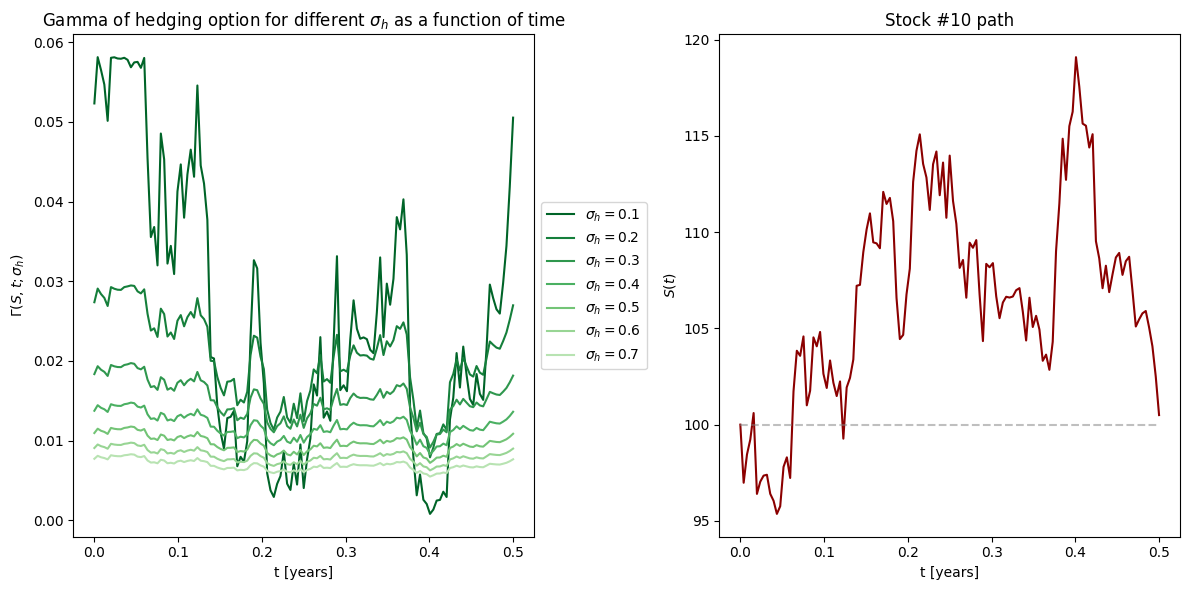

In [7]:
N_path = 10
fig, axes = plt.subplots(1, 2, figsize=(12,6))  # 1 row, 2 columns

# --- Left plot ---
for x in [0.1,0.2,0.3,0.4,0.5,0.6,0.7]:
    axes[0].plot(MC[0], bs.gamma((MC[1].T)[N_path], K, r, D, x, T, 'call'),
                 color=plt.cm.Greens(1-x), label=rf'$\sigma_h={x}$')
axes[0].set_xlabel(r't [years]')
axes[0].set_ylabel(r'$\Gamma(S,t;\sigma_h)$')
axes[0].set_title(r'Gamma of hedging option for different $\sigma_h$ as a function of time')
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# --- Right plot ---
# Example placeholder: replace with your second plot
axes[1].plot(MC[0], (MC[1].T)[N_path], color="darkred", label="example")
axes[1].hlines(y=K, xmin=0, xmax=T, colors="gray", linestyles="--", label="strike", alpha=0.5)
axes[1].set_title("Stock #"+str(N_path)+" path")
axes[1].set_xlabel(r't [years]')
axes[1].set_ylabel(r'$S(t)$')

plt.tight_layout()
plt.show()

Key takeaways:
1. Smaller $\sigma_h$ → more frequent re-hedging and larger fluctuations in $\Gamma$.
2. As a result, portfolios with smaller $\sigma_h$ are more sensitive to finite re-hedging interval effects.
3. Larger $\sigma_h$ → less frequent re-hedging, reduced sensitivity to path fluctuations.

We compare our numerical results with various re-hedging intervals to the average P&L in the continous limit,
\begin{align}
\mathbb{E}[P(\Pi)]=V^{(\sigma_h)}(S_0,t_0)-V^{(\sigma_{\text{imp}})}(S_0,t_0)+\frac12(\sigma^2-\sigma^2_h)\mathbb{E}\left[ \int_0^T   e^{-rt}  S^2 \Gamma^{(\sigma_h)} dt\right] \,.
\tag{13}
\end{align}

In [62]:
dt_range = [T/10,T/100,T/1000]
results = []   # list of dicts, one per dt

for dt in dt_range:
    # simulate once per dt, reuse for all sigma_h
    MC = mc.GBM_time_series_fast(S0, mu, sigmaReal, T, dt, m)

    rows = [va.vol_arb(S0, r, K, D, sH, sigmaReal, sigmaImp, T, dt, MC, True)
            for sH in sigmaH_range]
    dists, ps, stds = map(np.array, zip(*rows))   # -> arrays shape (len(sigmaH_range),)

    results.append({
        "dt": dt,
        "sigmaH": sigmaH_range,
        "dist": dists,
        "p": ps,
        "std": stds,
    })
PL_average_cont = np.array([va.vol_arb_average_PL(S0,r,K,D,sigmaH,sigmaReal,sigmaImp,mu,T) for sigmaH in sigmaH_range])

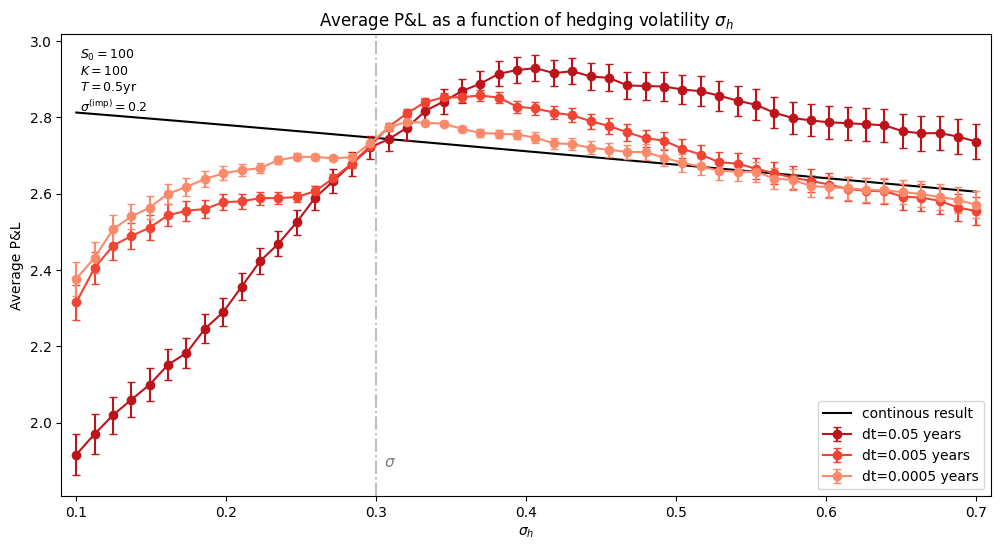

In [63]:
fig, ax = plt.subplots(figsize=(12,6))
colorsR = [plt.cm.Reds(0.8),  plt.cm.Reds(0.6),plt.cm.Reds(0.4)]
ax.plot(sigmaH_range,PL_average_cont[:,0],color='black',label="continous result")
# plt.plot(sigmaH_range,dists_percentiles[:,2],color='red',label="numeric")
ax.errorbar(sigmaH_range, results[0]['p'][:,2], yerr=results[0]['std'], fmt='-o',label=f'dt={dt_range[0]} years', color=colorsR[0], capsize=3)
ax.errorbar(sigmaH_range, results[1]['p'][:,2], yerr=results[1]['std'], fmt='-o',label=f'dt={dt_range[1]} years', color=colorsR[1], capsize=3)
ax.errorbar(sigmaH_range, results[2]['p'][:,2], yerr=results[2]['std'], fmt='-o',label=f'dt={dt_range[2]} years', color=colorsR[2], capsize=3)
plt.xlabel(r'$\sigma_{h}$')
plt.ylabel('Average P&L')
plt.title(r'Average P&L as a function of hedging volatility $\sigma_{h}$')
# plt.text(
#     0.5,2.6,             # position
#     f'dt = {dt:.6f} \n n = {m} \n T={T}',
#     fontsize=10, ha='center', va='center',
#     color='Black'           # optional
# )
plt.axvline(x=sigmaReal, color='k', linestyle='-.',alpha=0.25)
ax.text(
    sigmaReal+0.005, np.min(results[0]['p'][:,2]),             # position
    r'$\sigma$', # text (multi-line ok)
    # transform=ax.transAxes, # axes coords (0–1)
    fontsize=11, ha='left', va='top',
    color='gray'           # optional
)
ax.text(
    0.02,0.97,             # position
    r'$S_0=$'+str(S0)+"\n"+r'$K=$'+str(K)+"\n"+r'$T=$'+str(T)+r'$\text{yr}$'+"\n"+r'$\sigma^{(\text{imp})}=$'+str(sigmaImp), # text (multi-line ok)
    transform=ax.transAxes, # axes coords (0–1)
    fontsize=9, ha='left', va='top',
    color='Black'           # optional
)
plt.xlim(0.09,0.71) 
ax.legend()
plt.show()

As expected, we find good convergence in the continuous limit, particularly at larger values of $\sigma_h$, where the $\Gamma$ values are well-behaved. In this regime, fluctuations in $\Delta$ are reduced, leading to weaker dependence on the size of the re-hedging interval.”

## Continuous limit

The residual width at $\sigma_h=\sigma$ is due to the finite re-hedging interval. By decreasing the step size, we confirm the distributions narrow and converge to the continuous-time result.

In [28]:
dt_range =1/np.round(np.logspace(1,4,20) )
dists_dt = []
dists_percentiles_dt = []
dists_std = []
for dt in  dt_range:
    dist,p, std = va.vol_arb(S0,r,K,D,sigmaReal,sigmaReal,sigmaImp,T,dt,[mu,2000],False)
    dists_dt.append(dist)
    dists_percentiles_dt.append(p)
    dists_std.append(std)
dists_dt = np.array(dists_dt)
dists_percentiles_dt = np.array(dists_percentiles_dt)
dists_std = np.array(dists_std)

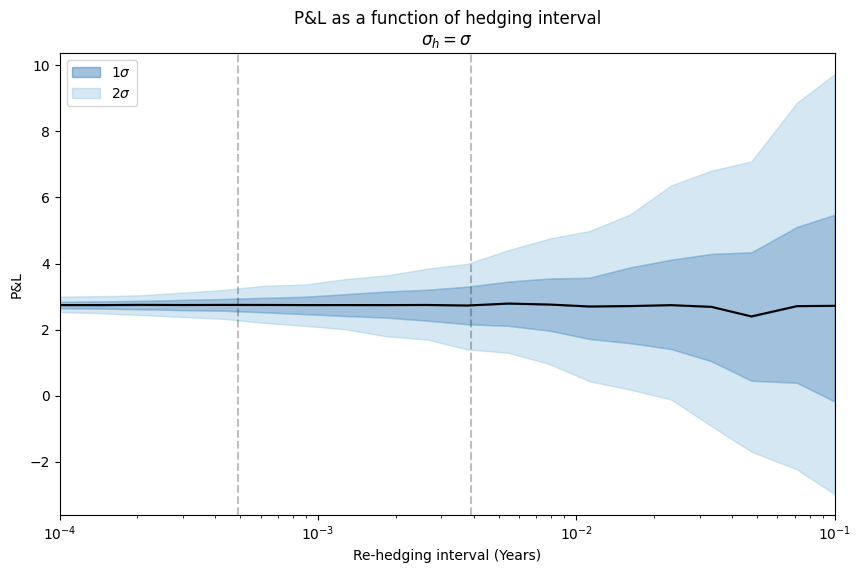

In [48]:
fig, ax = plt.subplots(figsize=(10,6))

colors= [plt.cm.Blues(0.8), plt.cm.Blues(0.4)]

ax.plot(dt_range,dists_percentiles_dt[:,2],color='black')


ax.fill_between(dt_range, dists_percentiles_dt[:,1], dists_percentiles_dt[:,2],alpha=0.4, color=colors[0], zorder=0,label=r'1$\sigma$')
ax.fill_between(dt_range, dists_percentiles_dt[:,3], dists_percentiles_dt[:,2],alpha=0.4, color=colors[0], zorder=0)
ax.fill_between(dt_range, dists_percentiles_dt[:,4], dists_percentiles_dt[:,3],alpha=0.4, color=colors[1], zorder=0,label=r'2$\sigma$')
ax.fill_between(dt_range, dists_percentiles_dt[:,0], dists_percentiles_dt[:,1],alpha=0.4, color=colors[1], zorder=0)
plt.legend()


# plt.grid(True)
plt.xlim(1e-4,1e-1) 
plt.axvline(x=1/255, color='k', linestyle='--',alpha=0.25)
plt.axvline(x=1/(255*8), color='k', linestyle='--',alpha=0.25)
plt.axvline(x=1/(255*8*60), color='k', linestyle='--',alpha=0.25)
plt.xlabel(r'Re-hedging interval (Years)')
plt.ylabel('P&L')
plt.title('P&L as a function of hedging interval\n'+ r'$\sigma_h = \sigma$ ')
ax.set_xscale("log")
plt.show()

In [42]:
PLTheo = float(bs.bs_formula_price(S0, K, r, D,sigmaReal, T, 'call')-bs.bs_formula_price(S0, K, r, D,sigmaImp, T, 'call'))
PLnum = [dists_percentiles_dt[-1,2],dists_std[-1]]

The theoretical prediction for our choice of parameters is
\begin{align}
P(\Pi;\sigma_h=h)_{\text{theo.}} = V(S_0,t_0;\sigma)-V(S_0,t_0;\sigma_{\text{imp}}) = 2.746\,,
\end{align}
where we disregard the very small numerical error from the built-in $\texttt{norm.cdf(x)}$ function.  
Our best numerical estimate,
\begin{align}
P(\Pi;\sigma_h=h)_{\text{num.}} = 2.744 \pm 0.005 \;\;\; (\text{95\% C.L})\,,
\end{align}
is fully consistent with the theoretical value.

## Summary

- When implied and realized volatilities match, the hedged option is fair: expected P&L $\approx 0$.  
- Mismatch leads to predictable drift in the hedged portfolio:
  - Overestimating volatility → over-hedging → negative drift.  
  - Underestimating volatility → under-hedging → positive drift.  
- This illustrates how volatility arbitrage strategies exploit systematic gaps between implied and realized volatility, transforming model mispricing into predictable profit or loss.
- We confirmed numerically the convergence of our results to the continious limit.  